In [12]:
# Append to sys path temporarily to allow import of custom module
import sys
sys.path.append("../../")
from cascid.database import get_db
from cascid.image_sampling import apply_transform

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from typing import Tuple

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

In [2]:
db = get_db()
db

patient_id  lesion_id  smoke  drink background_father background_mother  \
0      PAT_1516       1765    NaN    NaN               NaN               NaN   
1        PAT_46        881  False  False         POMERANIA         POMERANIA   
2      PAT_1545       1867    NaN    NaN               NaN               NaN   
3      PAT_1989       4061    NaN    NaN               NaN               NaN   
4       PAT_684       1302  False   True         POMERANIA         POMERANIA   
...         ...        ...    ...    ...               ...               ...   
2293   PAT_1708       3156    NaN    NaN               NaN               NaN   
2294     PAT_46        880  False  False         POMERANIA         POMERANIA   
2295   PAT_1343       1217    NaN    NaN               NaN               NaN   
2296    PAT_326        690  False  False         POMERANIA         POMERANIA   
2297   PAT_1714       3189    NaN    NaN               NaN               NaN   

      age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0       8       NaN     NaN                 NaN  ...        NaN        NEV   
1      55     False  FEMALE                True  ...        5.0        BCC   
2      77       NaN     NaN                 NaN  ...        NaN        ACK   
3      75       NaN     NaN                 NaN  ...        NaN        ACK   
4      79     False    MALE                True  ...        5.0        BCC   
...   ...       ...     ...                 ...  ...        ...        ...   
2293   73       NaN     NaN                 NaN  ...        NaN        ACK   
2294   55     False  FEMALE                True  ...       12.0        BCC   
2295   74       NaN     NaN                 NaN  ...        NaN        SEK   
2296   58      True  FEMALE                True  ...        4.0        BCC   
2297   41       NaN     NaN                 NaN  ...        NaN        SEK   

       itch   grew   hurt  changed  bleed elevation                 img_id  \
0     False  False  False    False  False     False  PAT_1516_1765_530.png   
1      True   True  False     True   True      True     PAT_46_881_939.png   
2      True  False  False    False  False     False  PAT_1545_1867_547.png   
3      True  False  False    False  False     False  PAT_1989_4061_934.png   
4      True   True  False    False   True      True   PAT_684_1302_588.png   
...     ...    ...    ...      ...    ...       ...                    ...   
2293   True  False  False    False  False     False  PAT_1708_3156_175.png   
2294   True   True  False     True  False     False     PAT_46_880_140.png   
2295  False  False  False    False  False     False  PAT_1343_1217_404.png   
2296   True  False  False    False  False      True    PAT_326_690_823.png   
2297  False   True  False    False  False      True  PAT_1714_3189_989.png   

     biopsed  
0      False  
1       True  
2      False  
3      False  
4       True  
...      ...  
2293   False  
2294    True  
2295   False  
2296    True  
2297   False  

[2298 rows x 26 columns]

In [3]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298 entries, 0 to 2297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           2298 non-null   object 
 1   lesion_id            2298 non-null   int64  
 2   smoke                1494 non-null   object 
 3   drink                1494 non-null   object 
 4   background_father    1480 non-null   object 
 5   background_mother    1476 non-null   object 
 6   age                  2298 non-null   int64  
 7   pesticide            1494 non-null   object 
 8   gender               1494 non-null   object 
 9   skin_cancer_history  1494 non-null   object 
 10  cancer_history       1494 non-null   object 
 11  has_piped_water      1494 non-null   object 
 12  has_sewage_system    1494 non-null   object 
 13  fitspatrick          1494 non-null   float64
 14  region               2298 non-null   object 
 15  diameter_1           1494 non-null   f

In [4]:
df_filtered = db[["patient_id", "lesion_id", "diameter_1", "diameter_2", "diagnostic", "fitspatrick", "img_id"]]
df_filtered

patient_id  lesion_id  diameter_1  diameter_2 diagnostic  fitspatrick  \
0      PAT_1516       1765         NaN         NaN        NEV          NaN   
1        PAT_46        881         6.0         5.0        BCC          3.0   
2      PAT_1545       1867         NaN         NaN        ACK          NaN   
3      PAT_1989       4061         NaN         NaN        ACK          NaN   
4       PAT_684       1302         5.0         5.0        BCC          1.0   
...         ...        ...         ...         ...        ...          ...   
2293   PAT_1708       3156         NaN         NaN        ACK          NaN   
2294     PAT_46        880        13.0        12.0        BCC          3.0   
2295   PAT_1343       1217         NaN         NaN        SEK          NaN   
2296    PAT_326        690         5.0         4.0        BCC          3.0   
2297   PAT_1714       3189         NaN         NaN        SEK          NaN   

                     img_id  
0     PAT_1516_1765_530.png  
1        PAT_46_881_939.png  
2     PAT_1545_1867_547.png  
3     PAT_1989_4061_934.png  
4      PAT_684_1302_588.png  
...                     ...  
2293  PAT_1708_3156_175.png  
2294     PAT_46_880_140.png  
2295  PAT_1343_1217_404.png  
2296    PAT_326_690_823.png  
2297  PAT_1714_3189_989.png  

[2298 rows x 7 columns]

In [5]:
df_filtered_null = df_filtered[df_filtered.isna().any(axis=1)] # Select rows where there is any null value
df_filtered_not_null = df_filtered[~(df_filtered.isna().any(axis=1))] # Select rows where there is any null value
df_filtered_null, df_filtered_not_null

(     patient_id  lesion_id  diameter_1  diameter_2 diagnostic  fitspatrick  \
 0      PAT_1516       1765         NaN         NaN        NEV          NaN   
 2      PAT_1545       1867         NaN         NaN        ACK          NaN   
 3      PAT_1989       4061         NaN         NaN        ACK          NaN   
 5      PAT_1549       1882         NaN         NaN        SEK          NaN   
 8      PAT_1995       4080         NaN         NaN        ACK          NaN   
 ...         ...        ...         ...         ...        ...          ...   
 2288   PAT_1407       1402         NaN         NaN        ACK          NaN   
 2290   PAT_1294       1031         NaN         NaN        ACK          NaN   
 2293   PAT_1708       3156         NaN         NaN        ACK          NaN   
 2295   PAT_1343       1217         NaN         NaN        SEK          NaN   
 2297   PAT_1714       3189         NaN         NaN        SEK          NaN   
 
                      img_id  
 0     PAT_1516_176

In [6]:
df_filtered_not_null["diagnostic"].value_counts()

BCC    845
ACK    283
SCC    192
NEV     75
MEL     52
SEK     47
Name: diagnostic, dtype: int64

In [7]:
# Checking sklearn class distribution

# Split
_, _, y_train_split_test, y_test_split_test = train_test_split(df_filtered_not_null[["img_id"]].to_numpy(), df_filtered_not_null["diagnostic"].to_numpy())

# Count
train_distribution = pd.Series(y_train_split_test).value_counts(normalize=True)
test_distribution = pd.Series(y_test_split_test).value_counts(normalize=True)
original_distribution = df_filtered_not_null["diagnostic"].value_counts(normalize=True)

# Show dataframe
print("Relative class frequency (0-1):")
pd.DataFrame({
    "train":train_distribution,
    "test": test_distribution,
    "original": original_distribution
})

Relative class frequency (0-1):


train      test  original
BCC  0.562500  0.574866  0.565596
ACK  0.193750  0.176471  0.189424
SCC  0.130357  0.122995  0.128514
NEV  0.050000  0.050802  0.050201
MEL  0.033036  0.040107  0.034806
SEK  0.030357  0.034759  0.031459

In [8]:
df_filtered_not_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 1 to 2296
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   patient_id   1494 non-null   object 
 1   lesion_id    1494 non-null   int64  
 2   diameter_1   1494 non-null   float64
 3   diameter_2   1494 non-null   float64
 4   diagnostic   1494 non-null   object 
 5   fitspatrick  1494 non-null   float64
 6   img_id       1494 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 93.4+ KB


# Diameter prediction model

In [9]:
# Split dataset for diameter 1 into validation, train, test
X_train, X_test, y_train, y_test = train_test_split(df_filtered_not_null[["img_id"]].to_numpy(), df_filtered_not_null["diameter_1"].to_numpy(), test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(f"{X_train.shape=}\n{X_test.shape=}\n{y_train.shape=}\n{y_test.shape=}\n{X_valid.shape=}\n{y_valid.shape=}\n")

X_train.shape=(956, 1)
X_test.shape=(299, 1)
y_train.shape=(956,)
y_test.shape=(299,)
X_valid.shape=(239, 1)
y_valid.shape=(239,)



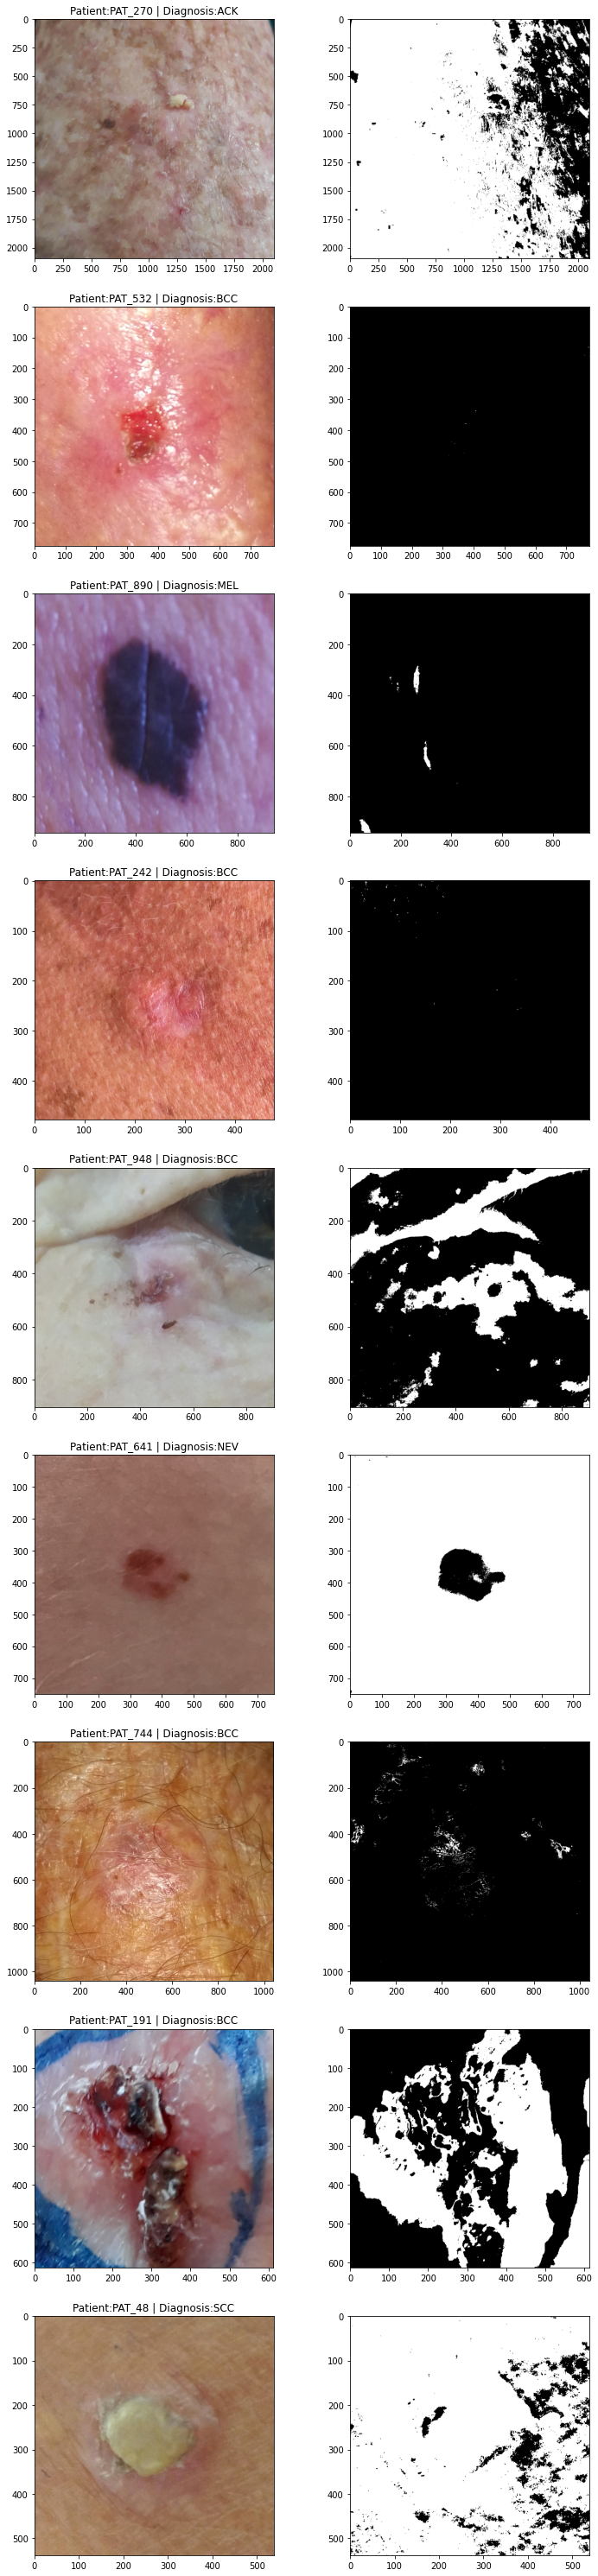

In [10]:
# https://www.researchgate.net/profile/Kseniia-Nikolskaia-2/publication/330074344_Skin_Detection_Technique_Based_on_HSV_Color_Model_and_SLIC_Segmentation_Method/links/5c2bb17da6fdccfc70762df0/Skin-Detection-Technique-Based-on-HSV-Color-Model-and-SLIC-Segmentation-Method.pdf
def clahe_transform(img: np.ndarray) -> np.ndarray:
    img_gray = img[:,:,0] # Red channel only
    img_blur = cv2.GaussianBlur(img_gray, (15,15), 0, 0) # Blur
    clahe = cv2.createCLAHE(clipLimit = 1.0, tileGridSize=(13,13)) 
    clahe_img = clahe.apply(img_blur) # Apply contrast enchance
    final_img = clahe_img
    return cv2.cvtColor(final_img, cv2.COLOR_GRAY2RGB) # return in RGB for matplotlib to show

def hsv_transform(img: np.ndarray) -> np.ndarray:
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    low_sat = 20
    high_sat = 120
    low_val = 80
    high_val = 180
    mask = cv2.inRange(
        img_hsv,
        np.array([0,low_sat,low_val]),
        np.array([45, high_sat, high_val])
    )
    mask2 = cv2.inRange(
        img_hsv,
        np.array([165,low_sat,low_val]),
        np.array([180, high_sat, high_val])
    )
    mask_comb = cv2.bitwise_or(mask, mask2)
    return cv2.cvtColor(mask_comb, cv2.COLOR_GRAY2RGB)

apply_transform(df_filtered_not_null, n_samples=9, f=hsv_transform, random_seed=42);

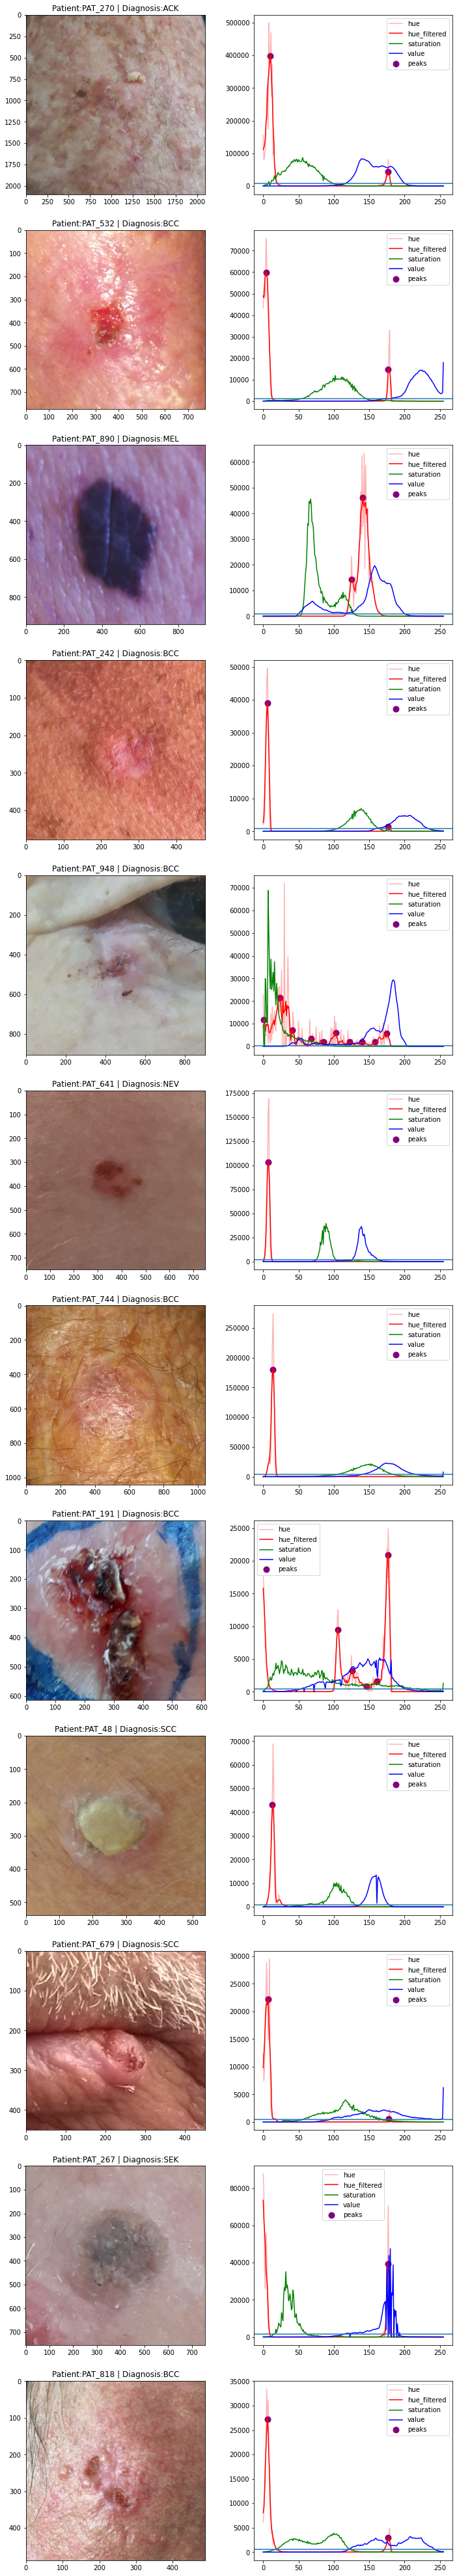

In [24]:
n_samples = 12
microdf = df_filtered_not_null.sample(n_samples, random_state=42).reset_index()
imgs = microdf['img_id'].to_list()
diganosis = microdf['diagnostic'].to_list()
patients = microdf['patient_id'].to_list()
fig = plt.figure(figsize=(12,6*n_samples))
axList = [0]*n_samples*2
for i in range(n_samples):
    axList[2*i] = fig.add_subplot(n_samples,2,2*i+1)
    axList[2*i+1] = fig.add_subplot(n_samples,2,2*i+2)
    filename = "../../data/images/" + imgs[i]
    img = cv2.imread(filename)[:,:,::-1]
    axList[2*i].imshow(img)
    axList[2*i].set_title("Patient:{0} | Diagnosis:{1}".format(patients[i], diganosis[i]))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hist1 = cv2.calcHist([img_hsv],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([img_hsv],[1],None,[256],[0,256])
    hist3 = cv2.calcHist([img_hsv],[2],None,[256],[0,256])
    axList[2*i+1].plot(hist1, label='hue', color='red', alpha=0.3)
    hist1_filtered = uniform_filter1d(hist1.flatten(), size=5)
    axList[2*i+1].plot(hist1_filtered, label='hue_filtered', color='red')
    axList[2*i+1].plot(hist2, label='saturation', color='green')
    axList[2*i+1].plot(hist3, label='value', color='blue')
    min_height_threshold = max(hist1_filtered.flatten())*0.02
    peaks, _ = find_peaks(hist1_filtered.flatten(), height=min_height_threshold, distance=5)
    axList[2*i+1].scatter(peaks, hist1_filtered[peaks], label="peaks", color="purple", lw=4)
    axList[2*i+1].axhline(min_height_threshold)
    axList[2*i+1].legend()

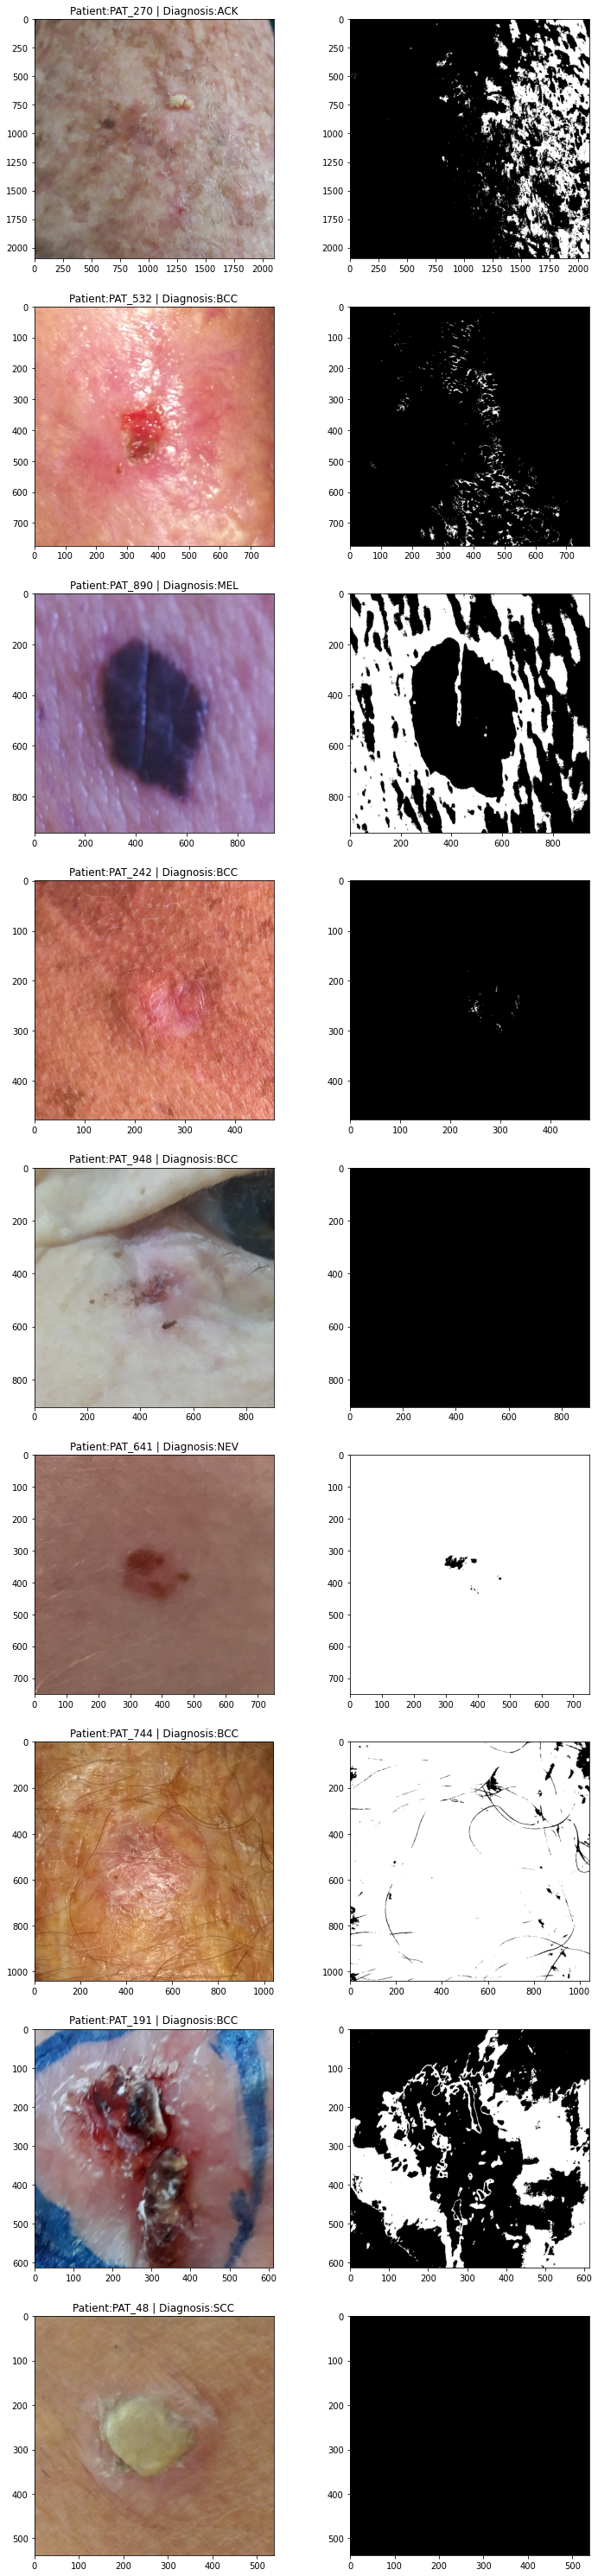

In [40]:
def extract_hue_peaks(img: np.ndarray, filter_size_1d: int = 5, min_peak_distance: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    img: Image as read from cv2 in BGR format
    Output (out): Index-paired lists of X and Y for each peak found. [out[0], out[1]] = list of coordinates for first peak.
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Convert to hsv
    hist1 = cv2.calcHist([img_hsv],[0],None,[256],[0,256]) # Get hue histogram
    hist1_filtered = uniform_filter1d(hist1.flatten(), size=filter_size_1d) # Apply 1d filter to reduce noise
    min_height_threshold = max(hist1_filtered.flatten())*0.02 # Remove peaks with too low hue frequency
    peaks, _ = find_peaks(hist1_filtered.flatten(), height=min_height_threshold, distance=min_peak_distance) # scipy peak finder
    out = list(zip(peaks.tolist(), hist1_filtered[peaks].tolist())) # Reorganize lists
    out = list(reversed(sorted(out, key= lambda x: float(x[1])))) # Sort by hue count
    return peaks, hist1_filtered[peaks]

def mask_by_hue_peak(img: np.ndarray) -> np.ndarray:
    """
    Receives and returns an image in BGR format.
    """
    peaks_x, peaks_y = extract_hue_peaks(img)
    mask = np.zeros(shape=(img.shape[0], img.shape[1]), dtype=np.uint8)
    low_sat = 10
    high_sat = 230
    low_val = 50
    high_val = 230
    hue_tol = 25

    if len(peaks_x) == 1:
        # Segment skin color
        mask = cv2.inRange(
            img,
            np.array([max(peaks_x[0]-hue_tol, 0),low_sat,low_val]),
            np.array([min(peaks_x[0]+hue_tol, 180), high_sat, high_val])
        )
        return cv2.cvtColor(~mask, cv2.COLOR_GRAY2RGB) # All not skin color
    
    # Segment second most common color
    mask = cv2.inRange(img,
        np.array([max(peaks_x[1]-hue_tol, 0),low_sat,low_val]),
        np.array([min(peaks_x[1]+hue_tol, 180), high_sat, high_val])
    )
    return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) # Second most common color

def blur(img: np.ndarray) -> np.ndarray:
    blur_img = cv2.GaussianBlur(img, ksize=(11,11), sigmaX=0.5)
    return cv2.GaussianBlur(blur_img, ksize=(5,5), sigmaX=0.5)

def blur_then_hue(img: np.ndarray) -> np.ndarray:
    return(mask_by_hue_peak(blur(img)))

apply_transform(df_filtered_not_null, n_samples=9, f=blur_then_hue, random_seed=42);